### Template Code

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


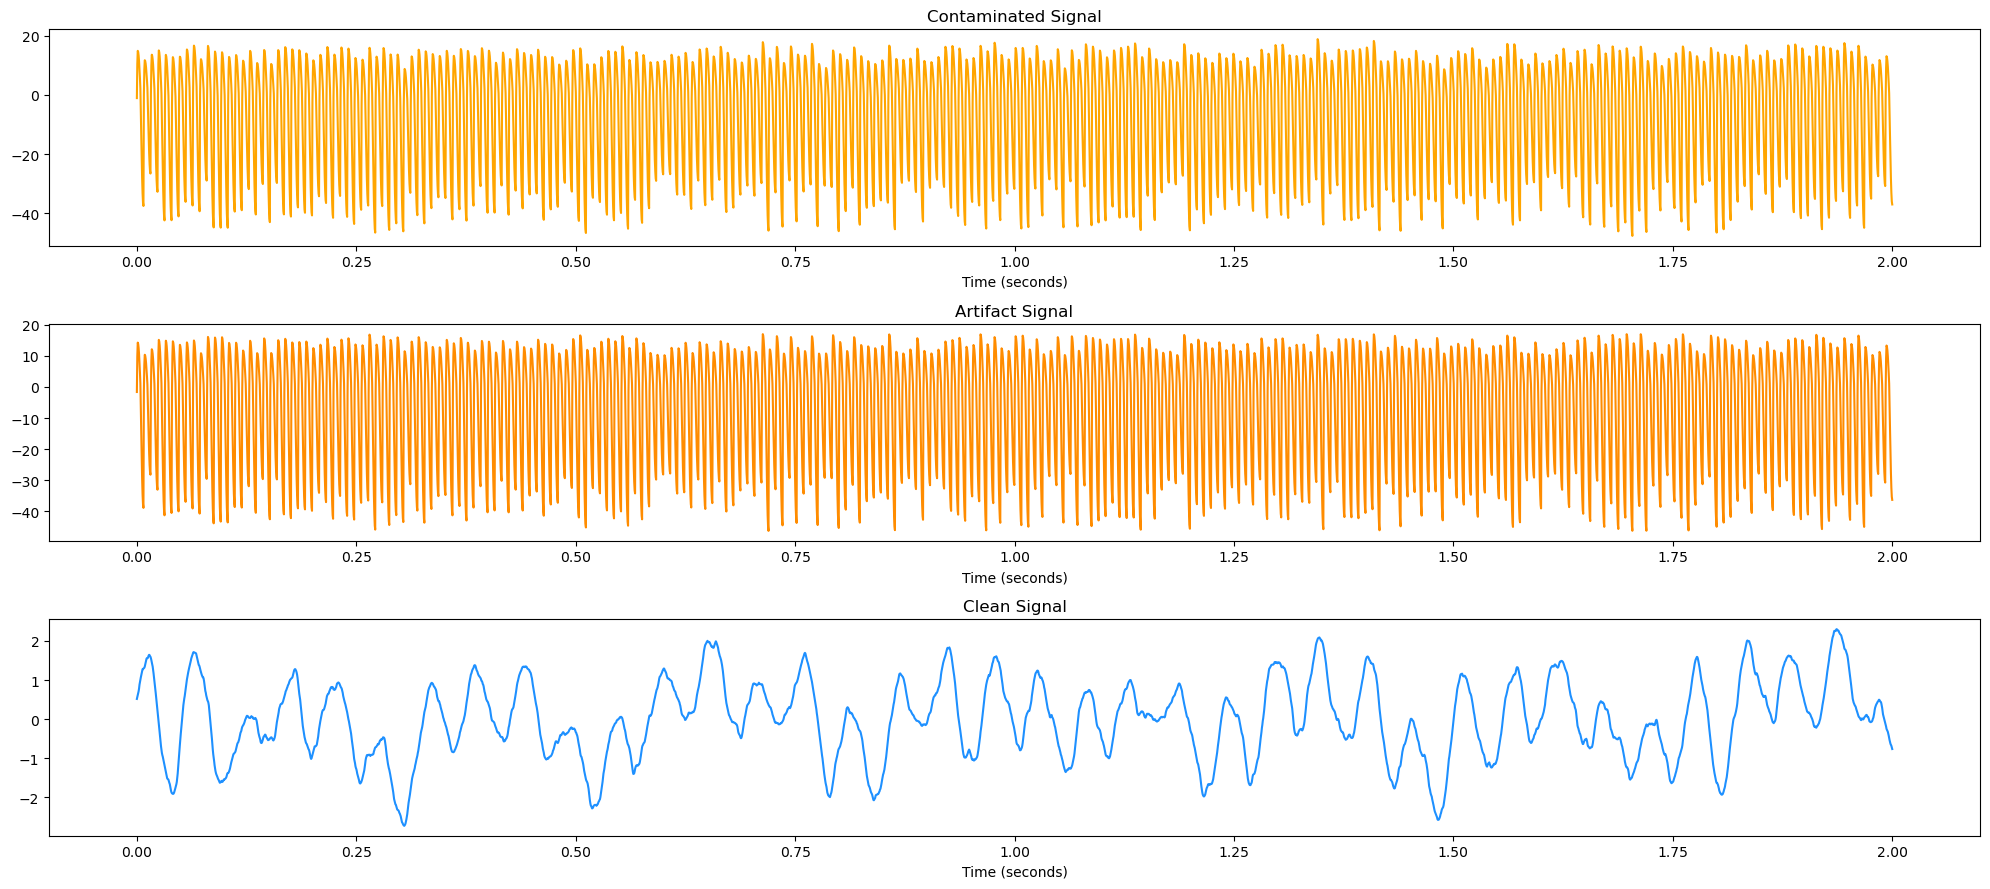

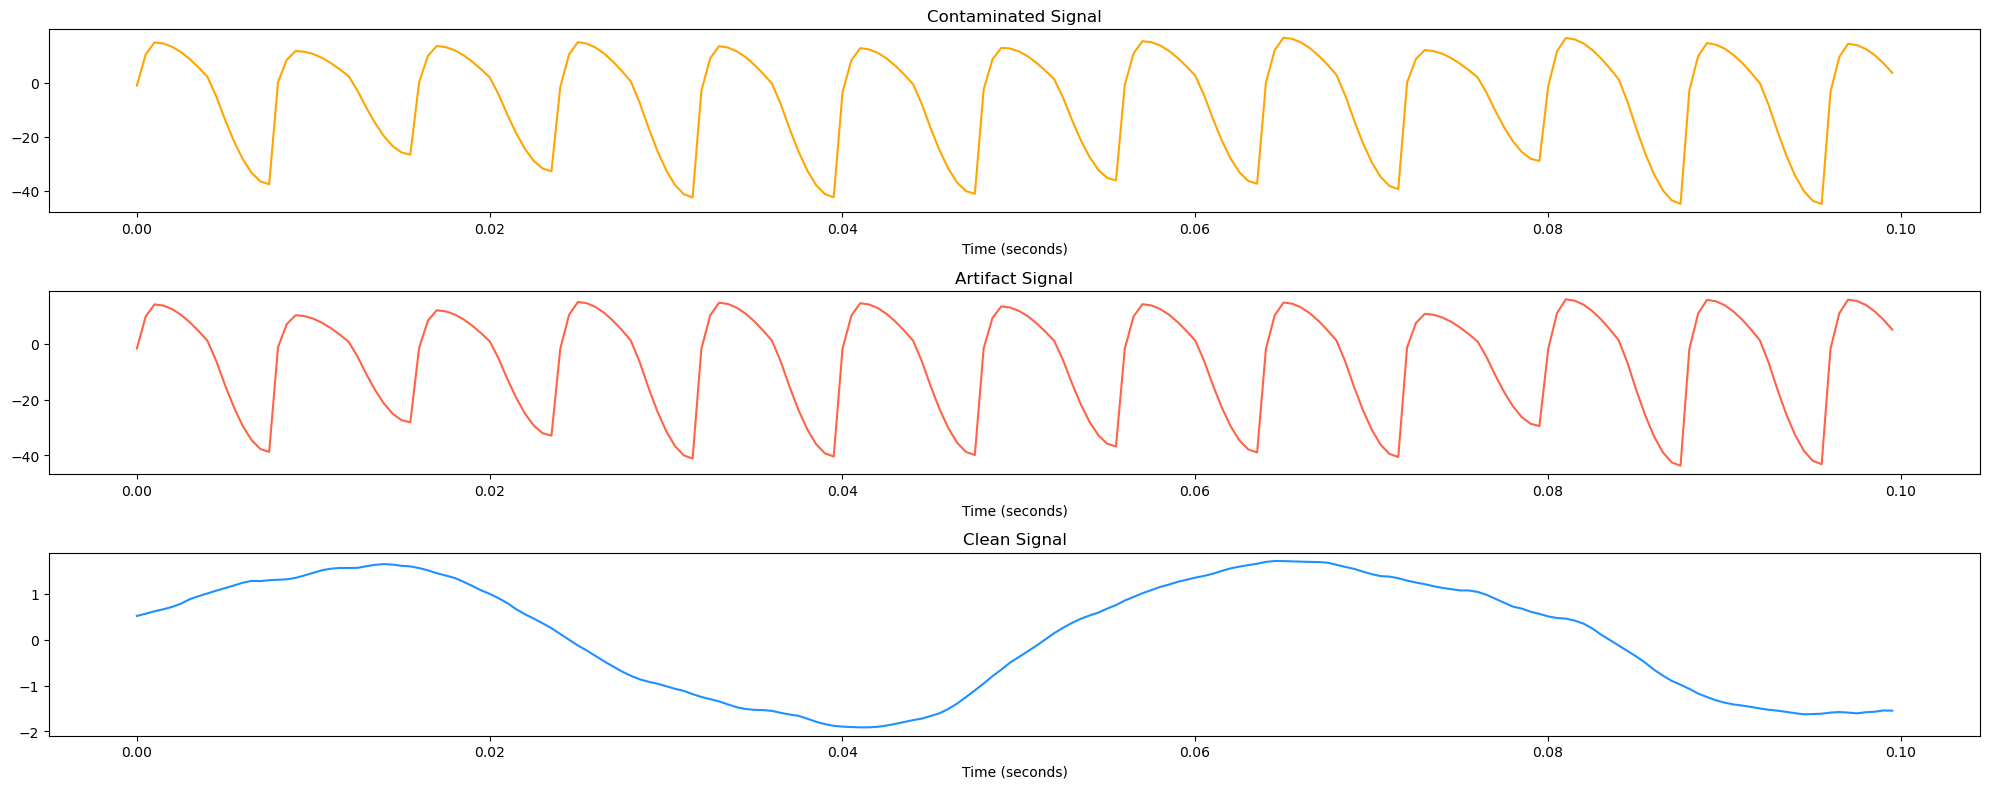

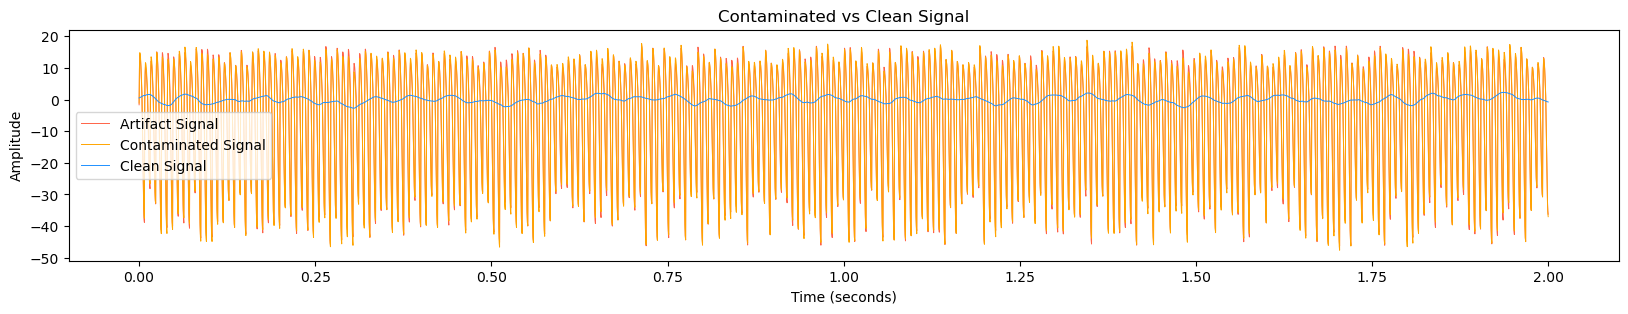

In [2]:
### 데이터 load & plot

import sys
sys.path.append('../plot/') # "~~/tool_code/plot/" (상대 경로)

from DataLoad import Data_Load_Plot, Result_Plot

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot() # Data loading 및 Plot 하는 함수

In [ ]:
# Data Transform(필요 경우에만. Frequency, Wave Transform 등)


In [ ]:
# Data Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

# 데이터에 맞게 수정해서 사용

scaler_x.fit(Contaminated_data[0].T)
scaler_y.fit(Clean_data[0].T)

for xx, yy in zip(Contaminated_data, Clean_data):
    scaled_x = scaler_x.transform(xx.T.reshape(-1, 1))
    scaled_y = scaler_y.transform(yy.T.reshape(-1, 1))
    X.append(scaled_x.reshape(xx.shape))
    y.append(scaled_y.reshape(yy.shape))

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

In [ ]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가) -> 모델에 따라 필요시 사용
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Model (모델에 따라 수정)

class CNN2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(CNN2D, self).__init__()
               
    def forward(self, x):
        
        return x_out

In [ ]:
# Parameter

num_samples = 4000
height = 12
width = 2000

model = CNN2D().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 모델 학습
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

In [ ]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')

In [ ]:
# inverse scaling (time domain 기준)
Contaminated_inverse_scaled = torch.tensor([])
Clean_inverse_scaled = torch.tensor([])
SACed_inverse_scaled = torch.tensor([])

for x, y, z in zip(Contaminated, SACed, Clean):
    x = scaler_x.inverse_transform(x.T.reshape(-1, 1))
    y = scaler_y.inverse_transform(y.T.reshape(-1, 1))
    z = scaler_y.inverse_transform(z.T.reshape(-1, 1))

    Contaminated_inverse_scaled = torch.cat((Contaminated_inverse_scaled, x.squeeze().cpu()), 0)
    Clean_inverse_scaled = torch.cat((Clean_inverse_scaled, y.squeeze().cpu()), 0)
    SACed_inverse_scaled = torch.cat((SACed_inverse_scaled, y_pred.squeeze().cpu()), 0)

# Time / Frequency Plotting
Result_Plot(Contaminated_inverse_scaled[0], Clean_inverse_scaled[0], SACed_inverse_scaled[0]) # 결과 Plot 하는 함수